<a href="https://colab.research.google.com/github/SerSanC/Word2Vec-Simpson-Project/blob/main/Word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency
from gensim.models.phrases import Phrases, Phraser

import spacy  # For preprocessing
import multiprocessing

from gensim.models import Word2Vec

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


In [2]:
!python -m spacy download en_core_web_sm

2022-10-19 07:10:05.444069: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 7.2 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
def scatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 0 to 19 dimensions with PCA
    reduc = PCA(n_components=19).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    

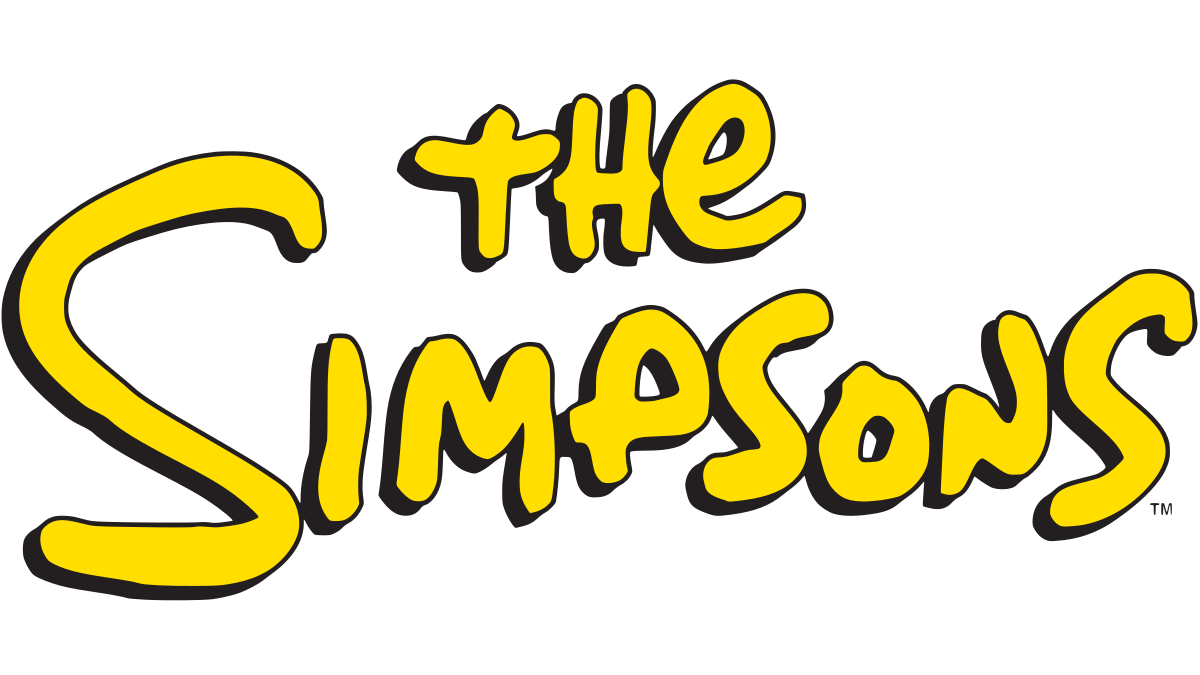

# The Data

The Simpsons is an American animated sitcom created by Matt Groening for the Fox Broadcasting Company. The series is a satirical depiction of American life, epitomized by the Simpson family, which consists of Homer, Marge, Bart, Lisa, and Maggie. The show is set in the fictional town of Springfield and parodies American culture and society, television, and the human condition. 

This dataset contains the character who speaks and the raw text from the line of dialogue. It can be found here: 

https://www.kaggle.com/datasets/pierremegret/dialogue-lines-of-the-simpsons

# Preprocessing

In [4]:
from google.colab import files

uploaded = files.upload()

Saving simpsons_dataset.csv to simpsons_dataset (1).csv


In [5]:
df = pd.read_csv('simpsons_dataset.csv')
df.shape

(158314, 2)

In [6]:
df.head()

,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...


In [7]:
df['raw_character_text']

0                     Miss Hoover
1                    Lisa Simpson
2                     Miss Hoover
3                    Lisa Simpson
4         Edna Krabappel-Flanders
                   ...           
158309                Miss Hoover
158310                Miss Hoover
158311                Miss Hoover
158312               Ralph Wiggum
158313                      JANEY
Name: raw_character_text, Length: 158314, dtype: object

In [8]:
len(df['raw_character_text'].unique())

6759

In [9]:
df.isnull().sum()

raw_character_text    17814
spoken_words          26459
dtype: int64

In [10]:
df = df.dropna().reset_index(drop=True)
df.isnull().sum()

raw_character_text    0
spoken_words          0
dtype: int64

## Cleaning:

It consists of lemmatizing and removing the stopwords and non-alphabetic characters for each line of dialogue.

In [11]:
nlp = spacy.load("en_core_web_sm", disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

In [12]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['spoken_words'])
txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000)]

Add the results to a DataFrame to remove missing and duplicate values:

In [13]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(85954, 1)

## Bigrams:

Gensim Phrases package to automatically detect common phrases (bigrams) from a list of sentences. https://radimrehurek.com/gensim/models/phrases.html

The main reason we do this is to catch words like "mr_burns" or "bart_simpson".

In [14]:
sent = [row.split() for row in df_clean['clean']]



Creates the relevant phrases from the list of sentences:



In [15]:
phrases = Phrases(sent, min_count=30, progress_per=10000)



The goal of Phraser() is to cut down memory consumption of Phrases(), by discarding model state not strictly needed for the bigram detection task


In [16]:
bigram = Phraser(phrases)



Transform the corpus based on the bigrams detected:


In [17]:
sentences = bigram[sent]

## Most Frequent Words: 

Mainly a sanity check of the effectiveness of the lemmatization, removal of stopwords, and addition of bigrams.

In [18]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

29674

In [19]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['oh', 'like', 'know', 'get', 'hey', 'think', 'come', 'right', 'look', 'want']

# Training the model

### Gensim Word2Vec Implementation:

We use Gensim implementation of word2vec: https://radimrehurek.com/gensim/models/word2vec.html

In [20]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

In this first step, I set up the parameters of the model one-by-one.
I do not supply the parameter sentences, and therefore leave the model uninitialized, purposefully.


##### **The parameters**:

  
*   **min_count** (type:int) = Ignores all words with total absolute frequency lower than this - (2, 100)
*   **window** (type:int) = The maximum distance between the current and predicted word within a sentence. E.g. window words on the left and window words on the left of our target - (2, 10)

* **size** (type:int) = Dimensionality of the feature vectors - (50, 300)

* **sample** (type:float) = The threshold for configuring which higher-frequency words are randomly downsampled. Highly influencial - (0, 1e-5)

* **alpha** (type:float) = The initial learning rate - (0.01, 0.05)

* **min_alpha** (type:float) = Learning rate will linearly drop to min_alpha as training progresses. To set it: alpha - (min_alpha * epochs) ~ 0.00

* **negative** (type:int) = If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown. If set to 0, no negative sampling is used. - (5, 20)

* **workers** (type:int) = Use these many worker threads to train the model (faster training with multicore machines)



In [21]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

Here it builds the vocabulary from a sequence of sentences and thus initialized the model. 

I noticed that these two parameters, and in particular sample, have a great influence over the performance of a model. Displaying both allows for a more accurate and an easier management of their influence.

In [22]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.06 mins


Finally, trains the model. 


In [23]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=35, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 1.89 mins


## Exploring the model
### Most similar to:

Here, we will ask our model to find the word most similar to some of the most iconic characters of the Simpsons!

<img src="https://static.wikia.nocookie.net/lossimpson/images/e/ed/Homero2006.png/revision/latest/top-crop/width/360/height/360?cb=20211004041814&path-prefix=es" alt="drawing" width="200"/>

Let's see what we get for the show's main character:

In [24]:
w2v_model.wv.most_similar(positive=["homer"])

[('marge', 0.6636262536048889),
 ('hammock', 0.6553223729133606),
 ('gee', 0.6490918397903442),
 ('depressed', 0.6318271160125732),
 ('bongo', 0.6094414591789246),
 ('sweetheart', 0.5976565480232239),
 ('attract', 0.5962565541267395),
 ('creepy', 0.5957157611846924),
 ('humiliate', 0.5946232080459595),
 ('snuggle', 0.5920413136482239)]

<img src="https://vignette.wikia.nocookie.net/simpsons/images/0/0b/Marge_Simpson.png/revision/latest?cb=20180626055729" alt="drawing" width="150"/>

What about Marge now?

In [25]:
w2v_model.wv.most_similar(positive=["marge"])

[('homer', 0.6636263132095337),
 ('sure', 0.6502142548561096),
 ('badly', 0.6441315412521362),
 ('husband', 0.6187116503715515),
 ('sorry', 0.618095874786377),
 ('hammock', 0.604568600654602),
 ('snuggle', 0.6034162640571594),
 ('married', 0.5970580577850342),
 ('becky', 0.5959961414337158),
 ('arrange', 0.5957216024398804)]

<img src="https://vignette.wikia.nocookie.net/simpsons/images/6/65/Bart_Simpson.png/revision/latest?cb=20180319061933" alt="drawing" width="150"/>

Let's check Bart now:

In [26]:
w2v_model.wv.most_similar(positive=["bart"])

[('lisa', 0.7219204902648926),
 ('convince', 0.6812507510185242),
 ('jealous', 0.6513934135437012),
 ('mom', 0.6499152183532715),
 ('embarrassing', 0.6459318399429321),
 ('creepy', 0.6274380683898926),
 ('mom_dad', 0.6241447925567627),
 ('milhouse', 0.6228678822517395),
 ('maggie', 0.6211678981781006),
 ('strangle', 0.6211638450622559)]


## Similarities:

Here, we will see how similar are two words to each other :


In [27]:
w2v_model.wv.similarity('maggie', 'baby')

0.6132421

In [28]:
w2v_model.wv.similarity('bart', 'milhouse')

0.6228679

In [29]:
w2v_model.wv.similarity('homer', 'marge')

0.6636263

In [30]:
w2v_model.wv.similarity('homer', 'patty')

0.29546133

In [31]:
w2v_model.wv.similarity('milhouse', 'patty')

0.16713715

In [32]:
w2v_model.wv.similarity("moe", 'tavern')

0.8627085

## Odd-One-Out:

Here, we ask our model to give us the word that does not belong to the list!

In [33]:
w2v_model.wv.doesnt_match(["nelson", "bart", "milhouse"])

/usr/local/lib/python3.7/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'nelson'

In [34]:
w2v_model.wv.doesnt_match(['homer', 'patty', 'selma'])

'homer'

In [35]:
w2v_model.wv.doesnt_match(['homer', 'patty', 'selma','marge'])

'homer'

## Analogy difference:

In [36]:
w2v_model.wv.most_similar(positive=["woman", "homer"], negative=["man"], topn=3)

[('marge', 0.5775816440582275),
 ('married', 0.5560977458953857),
 ('sorry', 0.5495059490203857)]

In [37]:
w2v_model.wv.most_similar(positive=["woman", "bart"], negative=["man"], topn=3)

[('jealous', 0.6153336763381958),
 ('lisa', 0.5760858058929443),
 ('embarrassing', 0.5705671906471252)]

# t-SNE visualizations:

t-SNE is a non-linear dimensionality reduction algorithm that attempts to represent high-dimensional data and the underlying relationships between vectors in a lower-dimensional space (a good tutorial: https://medium.com/@luckylwk/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b).

## 10 Most similar words vs. 8 Random words:
Let's compare where the vector representation of Homer, his 10 most similar words from the model, as well as 8 random ones, lies in a 2D graph:

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


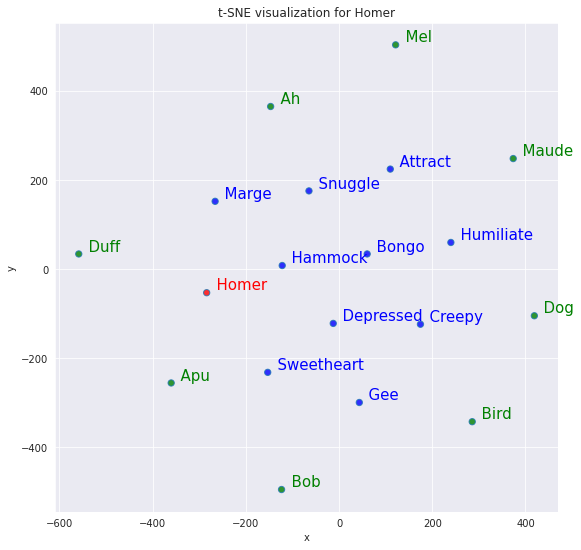

In [38]:
scatterplot(w2v_model, 'homer', ['dog', 'bird', 'ah', 'maude', 'bob', 'mel', 'apu', 'duff'])

The 10 most similar words to Homer ends up around him, so does Apu and (sideshow) Bob, two recurrent characters.

## 10 Most similar words vs. 10 Most dissimilar

This time, let's compare where the vector representation of Bart and her 10 most similar words from the model lies compare to the vector representation of the 10 most dissimilar words to Bart:

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


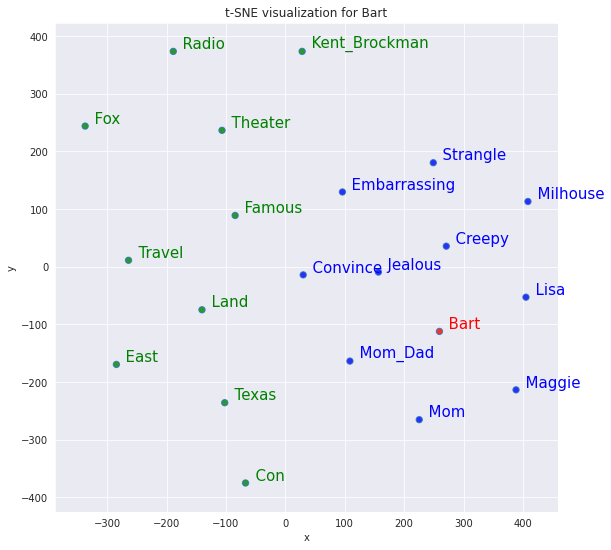

In [39]:
scatterplot(w2v_model, 'bart', [i[0] for i in w2v_model.wv.most_similar(negative=["bart"])])

## 10 Most similar words vs. 11th to 20th Most similar words:

Finally, we are going to plot the most similar words to Mr. Burns ranked 1st to 10th versus the ones ranked 11th to 20th:

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


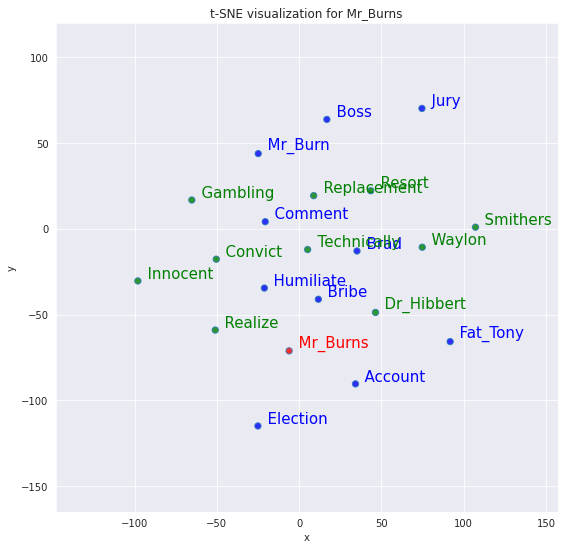

In [40]:
scatterplot(w2v_model, "mr_burns", [t[0] for t in w2v_model.wv.most_similar(positive=["mr_burns"], topn=20)][10:])

As we can see, all the 20 words are forming one cluster around Mr. Burns.
